# Purpose:

This notebook intends to demonstrate creation of a library of PSFs and use them to generate a post-coronagraph datacube.

Before the library is created, a monochromatic scene is generated for testing purposes. 


### NOTES:

no qualitative difference between ratios images of 3AU zodi with 1mas and 3 mas sampling.







In [1]:
from importlib import reload

import hlc_processing
reload(hlc_processing)

#dependencies:

import astropy.io.fits as fits
import astropy.units as u
import os
import numpy as np
import poppy.utils as utils
import poppy
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from matplotlib.colors import LogNorm
#%matplotlib inline
import glob

home = os.path.expanduser("~/")

import time

from utils import displ_scale  

#test_input=np.ones([2,3,3])

#webbpsf.setup_logging(level="WARN") ##switching logging from info to warn made propagation 2x faster

#print(webbpsf.__version__)
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':"nearest"})




In [2]:
#import ipyparallel as ipp
#rc = ipp.Client()
#with rc[:].sync_imports():
#    import numpy
#%px print('hi')

In [3]:
print(os.getcwd())
my_home_dir = os.getcwd()
print(my_home_dir)

C:\Users\Kian\Documents\GitHub\wfirst_dust_detection
C:\Users\Kian\Documents\GitHub\wfirst_dust_detection


In [4]:
#ouput parameters:

#lambda/D/4 resolution:
det_oversample=4

resel = (575*u.nm/(2.4*u.m)*u.radian).to(u.arcsec)

out_pixscale = (resel/det_oversample).value


In [5]:
out_pixscale


0.012354402457508377

## Plot input

## Create grid of pixel coordinates



In [6]:
debes_models = glob.glob(my_home_dir+"\DebesModels\*\**.fits",recursive = True)
debes_models

['C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc0_r0.1.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc0_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc0_r0.3.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc0_r0.4.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc0_r0.5.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc30_r0.1.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc30_r0.2.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annulus\\annulus_inc30_r0.3.fits',
 'C:\\Users\\Kian\\Documents\\GitHub\\wfirst_dust_detection\\DebesModels\\Model_Annul

In [7]:
localzodi = 5.2e-11 #Jy/pix (22 mags/sq as)


In [9]:
print(debes_models[0])
example_file = fits.open(debes_models[0])
example_file[0].header
localzodi_fits = fits.HDUList([fits.PrimaryHDU(localzodi*np.ones(example_file[0].data.shape))])
localzodi_fits[0].header["unit"] = "jansky/as**2"
localzodi_fits[0].header["CX"] = example_file[0].header["CX"]
localzodi_fits[0].header["CY"] = example_file[0].header["CY"]
localzodi_fits[0].header["PIXELSCL"] = example_file[0].header["PIXELSCL"]
localzodi_fits.writeto("localzodi.fits",overwrite=True)


C:\Users\Kian\Documents\GitHub\wfirst_dust_detection\DebesModels\Model_Annulus\annulus_inc0_r0.1.fits


In [10]:
"""for ring in debes_models:
    ringfits=fits.open(ring)
    ringfits[0].header["PIXELSCL"] = (0.003, "Pixel dimension in arcseconds")
    fits.writeto(ring,ringfits[0].data,ringfits[0].header,overwrite=True)"""

'for ring in debes_models:\n    ringfits=fits.open(ring)\n    ringfits[0].header["PIXELSCL"] = (0.003, "Pixel dimension in arcseconds")\n    fits.writeto(ring,ringfits[0].data,ringfits[0].header,overwrite=True)'

## Retrieve HLC PSF

In [12]:
offsetfiles = glob.glob(my_home_dir+"\offset_psfs\psf_xoff_*mas_yoff_*mas.fits") # Generate my own library of psfs? If so, how?
print(offsetfiles)

example_offaxis_psf = fits.open(offaxis_psfs[0])

[]


In [15]:
offsetfiles.sort() # at the moment offsetfiles is empty

xmas = np.array([float(fname.split("/")[-1][9:13]) for fname in offsetfiles])*u.milliarcsecond

hlc_header = fits.getheader(offsetfiles[0])

n = 200

HLCPSFs = np.empty([n,n,len(offsetfiles)])

for i,fname in enumerate(offsetfiles):
    HLCPSFs[:,:,i] = fits.getdata(fname)
xmas

HLC_header = fits.getheader(fname)

lambda_D = HLC_header["lambda_c"]*u.micron/(2.37*u.m)

HLC_plate_scale = (HLC_header["pixsize"]*lambda_D*u.radian).to(u.arcsec) #arcsec/pixel of HLC PSFs

#pixsize is HLC simulation pixel size in lambda_c/D  
HLC_header["PIXELSCL"] = HLC_plate_scale.value
HLC_plate_scale

IndexError: list index out of range

In [32]:
# The original Ewan code
#hlc_large_range = fits.open(home+"/projects/WFIRST/data/OS5_ADI_3.2/OS5_adi_3_highres_polx_lowfc_random_offset_psfs.fits")
#hlc_large_offsets = fits.open(home+"/projects/WFIRST/data/OS5_ADI_3.2/OS5_adi_3_highres_polx_lowfc_random_offset_psfs_offsets.fits")

hlc_large_range = fits.open(my_home_dir+"\offset_psfs\OS5_ADI_3.2\OS5_adi_3_highres_polx_lowfc_random_offset_psfs.fits")
print(hlc_large_range)

hlc_large_offsets = fits.open(my_home_dir+"\offset_psfs\OS5_ADI_3.2\OS5_adi_3_highres_polx_lowfc_random_offset_psfs_offsets.fits")
print(hlc_large_offsets)

# add the OS5 cube, starting at 225mas, outside the high resolution PSFs
lambda_D = 0.550*u.micron/(2.37*u.m)

trimmed = hlc_large_range[0].data[:,8:-9,8:-9] # replace the 8 with 0 or colon
xmas2 = np.array(list(hlc_large_offsets[0].data[:]*lambda_D.decompose().value*206265e3))*u.milliarcsecond
#HLCPSFs2 = np.concatenate(#[HLCPSFs,np.moveaxis(trimmed, 0, -1)],axis=2)
hlcpsfs = np.moveaxis(trimmed,0,-1)
    
fits.writeto("composite_cube.fits",hlcpsfs.T,overwrite = True)

xmas2

<Quantity [  0.      ,  43.08066 , 100.521545, 114.881775, 129.24199 ,
           157.96242 , 172.32265 , 186.68288 , 215.4033  , 229.76355 ,
           258.48398 , 287.2044  , 344.6453  , 387.72598 , 402.08618 ,
           416.4464  , 430.8066  , 445.16684 ] marcsec>

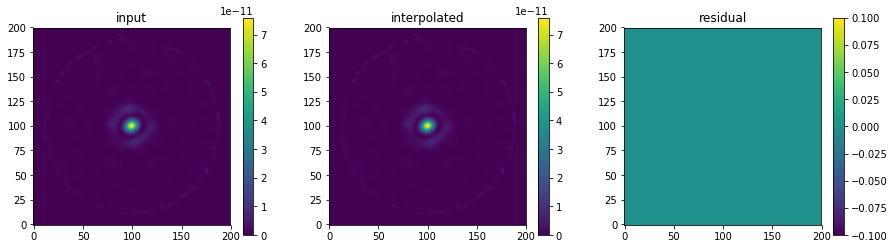

In [39]:
#interpolate over a grid
#see https://stackoverflow.com/a/28858633/2142498
from scipy.interpolate import RegularGridInterpolator 

n = 200

x = range(n) #(np.arange(-hlc_header["NAXIS1"]/2,hlc_header["NAXIS1"]/2)+.5)*hlc_header["PIXSIZE"]

y = range(n) #(np.arange(-hlc_header["NAXIS2"]/2,hlc_header["NAXIS2"]/2)+.5)*hlc_header["PIXSIZE"]

z = xmas2

my_interpolating_function = RegularGridInterpolator((x, y, z), hlcpsfs2,
                                                    bounds_error = False,
                                                    method = "nearest", #~2x faster than linear
                                                    fill_value = 0)

grid = np.meshgrid(x,y)
pts = np.vstack([np.vstack([grid[0].flatten(),grid[1].flatten()]),0*np.ones(len(grid[0].flatten()))]).T
interpped = my_interpolating_function(pts).reshape(n,n).T


plt.figure(figsize=[15,4])

# Plot the original PSF
plt.subplot(131)
plt.title("input")
plt.imshow(hlcpsfs[:,:,0])
plt.colorbar()
# Plot the interpolated PSF
plt.subplot(132)
plt.title("interpolated")
plt.imshow(interpped)
plt.colorbar()
# Plot the inerpolated - original PSF
plt.subplot(133)
plt.title("residual")
plt.imshow(interpped-hlcpsfs[:,:,0])
plt.colorbar()

plt.show()

In [40]:
hlc_processing.USE_OPENCV

False

In [15]:
mask_radius=0.7/HLC_header["pixsize"]

NameError: name 'HLC_header' is not defined

In [16]:
reload(hlc_processing)
planet3 = hlc_processing.closest_monochrome_PSF(-300*u.milliarcsecond,200*u.milliarcsecond,
                                              my_interpolating_function,
                                              xmas2,
                                              HLC_plate_scale,
                                              mask_radius=mask_radius)

%prun hlc_processing.closest_monochrome_PSF(-300*u.milliarcsecond,200*u.milliarcsecond,my_interpolating_function,xmas2,HLC_plate_scale,mask_radius=mask_radius)
plt.imshow(planet3[150:170,130:150])
plt.show()

#??Mask isn't quite circular

NameError: name 'my_interpolating_function' is not defined

In [17]:
thresh = 1e32

xmas2

NameError: name 'xmas2' is not defined

In [18]:
zodi_fname = "zodipic_10pc03mas01alpha.fits"


zodi_path = home + "projects/WFIRST/data/zodipic/" + zodi_fname

reload(hlc_processing)
core_mask_radius = .15*u.arcsec
im,zodi = hlc_processing.fit_to_hlc(zodi_path,
                                    my_interpolating_function,
                                    xmas2,
                                    HLC_plate_scale,
                                    display=True,
                                    thresh=thresh)

im_name = zodi_path[:-4]+"_HLC.fits"

zodi_header = fits.getheader(zodi_path)
zodi_header["thresh"]=thresh
zodi_header["coremask"]=core_mask_radius.value

fits.writeto(im_name,im,overwrite=True,header=zodi_header) #    fits.writeto(outfits,im,overwrite=True)

zodi_name = zodi_path+str(thresh)+"_input.fits"
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite = True)






NameError: name 'my_interpolating_function' is not defined

In [19]:
core_mask_radius = .15*u.arcsec
im,zodi = hlc_processing.fit_to_hlc(zodi_path,
                                    my_interpolating_function,
                                    xmas2,
                                    HLC_plate_scale,
                                    display=True,
                                    core_mask_radius=core_mask_radius,
                                    thresh=thresh)

im_name = zodi_path[:-4]+"_coremasked_HLC.fits"

zodi_header = fits.getheader(zodi_path)
zodi_header["thresh"] = thresh
zodi_header["coremask"] = core_mask_radius.value

fits.writeto(im_name,im, overwrite = True, header = zodi_header) #    fits.writeto(outfits,im,overwrite=True)

zodi_name = zodi_path+str(thresh)+"_coremasked_input.fits"
fits.writeto(zodi_name, zodi.filled(fill_value = 0), overwrite=True)






NameError: name 'my_interpolating_function' is not defined

In [20]:
zodi_name

NameError: name 'zodi_name' is not defined

In [21]:
reload(hlc_processing)
im,zodi = hlc_processing.fit_to_hlc(zodi_path,
                                    my_interpolating_function,
                                    xmas2,
                                    HLC_plate_scale,
                                    display = True,
                                    thresh = thresh)

NameError: name 'my_interpolating_function' is not defined

In [22]:
im_name = zodi_path[:-4]+"_HLC.fits"

zodi_header = HLC_header.copy()
zodi_header["thresh"] = thresh


fits.writeto(im_name,im,overwrite=True,header=zodi_header) # fits.writeto(outfits,im,overwrite=True)

zodi_name = zodi_path+"_input.fits"
fits.writeto(zodi_name,zodi.filled(fill_value = 0),overwrite = True)

NameError: name 'HLC_header' is not defined

In [23]:
zodi_fname = "zodipic_03pc03mas.fits"


zodi_path = home + "projects/WFIRST/data/zodipic/" + zodi_fname


im,zodi = hlc_processing.fit_to_hlc(zodi_path,
                                  my_interpolating_function,
                                  xmas2,
                                  HLC_plate_scale,
                                  thresh=thresh)

im_name = zodi_path[:-4]+"_HLC.fits"

zodi_header = HLC_header.copy()
zodi_header["thresh"] = thresh
fits.writeto(im_name,im,overwrite=True,header=zodi_header) #    fits.writeto(outfits,im,overwrite=True)

zodi_name = zodi_path+str(thresh)+".fits"
fits.writeto(zodi_name,zodi.filled(fill_value=0),overwrite=True)






NameError: name 'my_interpolating_function' is not defined

In [24]:
reload(hlc_processing)
zodi_file = home+"projects/WFIRST/data/zodipic/zodipic_10pc03mas.fits"


im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                  my_interpolating_function,
                                  xmas2,
                                  HLC_plate_scale,
                                  thresh=1e32)
im_name = zodi_file+"_HLC.fits"
fits.writeto(im_name,im,overwrite=True,header=fits.getheader(zodi_file) )#    fits.writeto(outfits,im,overwrite=True)


NameError: name 'my_interpolating_function' is not defined

In [25]:
reload(hlc_processing)
zodi_file = home+"projects/WFIRST/data/zodipic/zodipic_10pc03mas.fits"


im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                  my_interpolating_function,
                                  xmas2,
                                  HLC_plate_scale,
                                  core_mask_radius=core_mask_radius,
                                  thresh = 1e32)
im_name = zodi_file+"_coremasked_HLC.fits"
fits.writeto(im_name, im, overwrite = True, header = fits.getheader(zodi_file)) # fits.writeto(outfits,im,overwrite=True)


NameError: name 'my_interpolating_function' is not defined

In [26]:
reload(hlc_processing)
zodi_file = home+"projects/WFIRST/data/zodipic/zodipic_10pc03mas01alpha.fits"


im,zodi = hlc_processing.fit_to_hlc(zodi_file,
                                  my_interpolating_function,
                                  xmas2,
                                  HLC_plate_scale,
                                  thresh=thresh)
im_name = zodi_file+"_HLC"+str(thresh)+".fits"
fits.writeto(im_name, im, overwrite = True, header = fits.getheader(zodi_file)) # fits.writeto(outfits,im,overwrite=True)

NameError: name 'my_interpolating_function' is not defined

In [27]:
zodi_name = zodi_file+"_HLC"+str(thresh)+"_input.fits"
fits.writeto(zodi_name,zodi.filled(fill_value = 0), overwrite = True)


im_m,zodi_m = hlc_processing.fit_to_hlc(zodi_file,
                                      my_interpolating_function,
                                      xmas2,
                                      HLC_plate_scale,
                                      thresh=thresh,mask_radius=mask_radius)

im_m_name = zodi_file+"_HLC"+str(thresh)+"_masked"+str(mask_radius)+".fits"
fits.writeto(im_m_name, im_m, overwrite = True, header = fits.getheader(zodi_file))

NameError: name 'zodi' is not defined

In [28]:
im_m = fits.getdata(im_m_name)
zodi_m = fits.getdata(zodi_name)




NameError: name 'im_m_name' is not defined

In [29]:
zodi_fits = fits.open(zodi_file)
zodi_pixscale = zodi_fits[0].header["PIXELSCL"]*u.arcsecond

plt.figure(figsize=[6,9])

x_hlc,y_hlc = np.meshgrid(np.arange(-n/2,n/2),np.arange(-n/2,n/2))
x_hlc = (x_hlc+.5).flatten()*HLC_plate_scale
y_hlc = (y_hlc+.5).flatten()*HLC_plate_scale
halfpix_hlc = HLC_plate_scale.to(u.arcsec).value*0.5
halfpix = zodi_pixscale.to(u.arcsec).value*0.5



HLC_extent = ([x_hlc.min().to(u.arcsec).value-halfpix,
           x_hlc.max().to(u.arcsec).value+halfpix, 
           y_hlc.min().to(u.arcsec).value-halfpix,
            y_hlc.max().to(u.arcsec).value+halfpix])


fov=.4
pixnum = np.int(zodi_m.shape[0])
x,y = np.meshgrid(np.arange(-pixnum/2,pixnum/2),np.arange(-pixnum/2,pixnum/2))
x = (x+.5).flatten()*zodi_pixscale
y = (y+.5).flatten()*zodi_pixscale


zodi_extent = ([x.min().to(u.arcsec).value-halfpix,
           x.max().to(u.arcsec).value+halfpix, 
           y.min().to(u.arcsec).value-halfpix,
            y.max().to(u.arcsec).value+halfpix])

plt.subplot(311)
plt.title("Input")
plt.imshow(zodi_m,norm=LogNorm(),extent=zodi_extent)
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])

plt.colorbar()
plt.subplot(312)

plt.xlim([-fov,fov])
plt.ylim([-fov,fov])
plt.title("Unmasked PSF")

plt.imshow(im,interpolation="nearest",norm=LogNorm(),extent=HLC_extent,vmin=1e-15)



plt.xlim([-fov,fov])
plt.ylim([-fov,fov])


plt.colorbar()
plt.subplot(313)

plt.title("Masked PSF")
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])

plt.imshow(im_m,interpolation="nearest",norm=LogNorm(),extent=HLC_extent,vmin=1e-15)






plt.colorbar()


plt.tight_layout()
plt.savefig(zodi_file+"_input_outputs"+str(mask_radius)+"_mask.pdf",bbox_inches="tight")

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Kian/projects/WFIRST/data/zodipic/zodipic_10pc03mas01alpha.fits'

NameError: name 'my_interpolating_function' is not defined

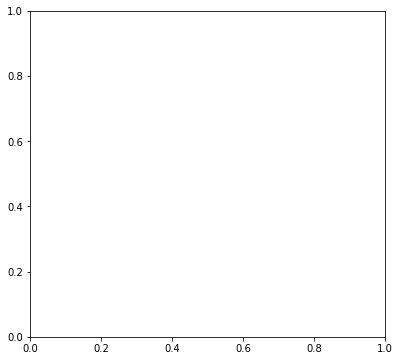

In [30]:
#check that coordinates match expectation.
plt.figure(figsize=[7*2,3*2])

plt.subplot(121)
planet1=hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,
                               0*u.milliarcsecond,
                               my_interpolating_function,xmas2,
                               HLC_plate_scale,
                              mask_radius=mask_radius) 
planet2=hlc_processing.closest_monochrome_PSF(0*u.milliarcsecond,-40*u.milliarcsecond,
                               my_interpolating_function,
                               xmas2,
                               HLC_plate_scale,
                               mask_radius=mask_radius)
planet3=hlc_processing.closest_monochrome_PSF(-200*u.milliarcsecond,200*u.milliarcsecond,
                               my_interpolating_function,
                               xmas2,
                               HLC_plate_scale,
                               mask_radius=mask_radius)
#plt.figure(figsize=[6,4])
plt.imshow(np.array(planet1/planet1.max()+planet2/planet2.max()+planet3/planet3.max()),
          cmap=plt.cm.plasma,interpolation="nearest",extent=HLC_extent)#,vmin=-8)
plt.grid()


plt.colorbar()

plt.subplot(122)
planet1=hlc_processing.closest_monochrome_PSF(100*u.milliarcsecond,
                               0*u.milliarcsecond,
                               my_interpolating_function,
                                              xmas2,
                                              HLC_plate_scale,
                              )#mask_radius=mask_radius) 
planet2=hlc_processing.closest_monochrome_PSF(0*u.milliarcsecond,-40*u.milliarcsecond,
                               my_interpolating_function,
                               xmas2,HLC_plate_scale,)#,mask_radius=mask_radius)
planet3=hlc_processing.closest_monochrome_PSF(-200*u.milliarcsecond,200*u.milliarcsecond,
                               my_interpolating_function,
                               xmas2,
                                              HLC_plate_scale,)#,mask_radius=mask_radius)
plt.imshow(np.array(planet1/planet1.max()+planet2/planet2.max()+planet3/planet3.max()),
          cmap=plt.cm.plasma,interpolation="nearest",extent=HLC_extent)#,vmin=-8)
plt.colorbar()
plt.grid()
plt.savefig("normalized_psfs"+str(mask_radius)+"_mask.pdf",bbox_inches="tight")
plt.show()

NameError: name 'im' is not defined

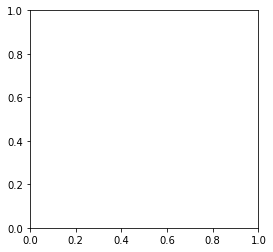

In [31]:
#plot ratio map and radial curve
plt.figure(figsize=[9,4])
plt.subplot(121)
ratio=im/im_m
#ratio.mask=zodi_m
plt.imshow(ratio,extent=HLC_extent,interpolation="nearest",
           vmin=0,vmax=10,#norm=LogNorm(),
           cmap=plt.cm.magma)
plt.colorbar()#orientation="horizontal")
plt.xlim([-fov,fov])
plt.ylim([-fov,fov])


plt.subplot(122)
plt.plot(x_hlc[0:200],ratio[:,100])
#plt.yscale("log")
plt.xlim([0,.3])
plt.ylim([0,10])
plt.xlabel("$\prime\prime$")
fits.writeto(im_m_name+"ratio.fits",ratio,zodi_fits[0].header,overwrite=True)
plt.savefig(im_m_name+"ratio.pdf",bbox_inches="tight")
plt.show()


In [32]:
zodi = fits.open(zodi_file)[0]

plt.figure(figsize=[8,8])

plt.subplot(221)
plt.imshow(zodi.data,norm=LogNorm(),extent=zodi_extent,)
plt.colorbar()

plt.ylabel("$\prime\prime$")

plt.xlim([-.25,.25])
plt.ylim([-.25,.25])

plt.title("Zodipic")

plt.subplot(222)

plt.imshow(zodi.data,extent=zodi_extent)#,norm=LogNorm(zodi.data[zodi>0].min(),zodi.data.max()))#zodi.data.min(),zodi.data.max))
plt.colorbar()
plt.title("Zodipic core")
plt.xlim([-.05,.05])
plt.ylim([-.05,.05])


#ax.set_yscale("log")
#plt.colorbar()

plt.subplot(223)
plt.title("Zodipic Included Flux")
plt.xlim([-.25,.25])
plt.ylim([-.25,.25])
plt.ylabel("$\prime\prime$")

plt.xlabel("$\prime\prime$")

plt.grid()

plt.imshow(zodi.data,extent=zodi_extent,norm=LogNorm(zodi.data[zodi.data>0].min(),zodi.data.max()))#zodi.data.min(),zodi.data.max))
plt.colorbar()
plt.subplot(224)

plt.imshow(im,extent=HLC_extent)
plt.colorbar()
plt.title("HLC Image of Included Flux")

plt.xlim([-.25,.25])
plt.ylim([-.25,.25])

plt.grid()
plt.xlabel("$\prime\prime$")

plt.tight_layout()
plt.show()

plt.savefig("Zodipic_HLC_1_5mas.png")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Kian/projects/WFIRST/data/zodipic/zodipic_10pc03mas01alpha.fits'

In [33]:
plt.imshow(im,norm=LogNorm())#1e-20,1e-15))
plt.colorbar()
plt.title("HLC Image of Included Flux")
plt.show()

NameError: name 'im' is not defined

In [34]:
#import webbpsf
from webbpsf import wfirst
import importlib
importlib.reload(wfirst)

ifs_spc = wfirst.CGI(pixelscale=out_pixscale)
ifs_spc.mode = 'DISKSPC_F721'#CHARSPC_F770' #
#ifs_spc.cgi_family = "DISKSPC"

ifs_spc.cgi_family = "CHARSPC"

FOV=2*1.64

#example cube 
input_fname = home+"projects/WFIRST/data/zodipic/zodipic_10pc3mas.fits"
dust = fits.open(input_fname)

#define adjustable cropping factor
border = 1
input_cube = dust[0].data#[:,border:-border,border:-border]#[:,90:-90,90:-90]#[:2,580:-580,580:-580]


dust[0].header["INPUT_FITS"] = input_fname
dust[0].header["PIXELSCL"] = 0.01425
dust[0].header["INPUT_flux"] = "Jy"

#location of center from Ds9 inspection
'''
DS9 coordinate notes, corners are from 0.5-213.5 and center is at 108.

in numpy coordinates the center is at 107,107

'''
center = (107-border)

# find parameters:
dim = input_cube.shape
if len(dim)>2:
    ny = dim[1]
    nx = dim[2]
else:
    ny = dim[0]
    nx = dim[1] 
#test that center is center by removing the flux
#input_cube [0,center,center] =1e-11



ModuleNotFoundError: No module named 'webbpsf'

In [35]:
HLCPSFs2[HLCPSFs2[:,:,:]<1e-12]=0

plt.imshow(HLCPSFs2[:,:,:],norm = LogNorm(vmax = 1e-4, vmin = 1e-13))


NameError: name 'HLCPSFs2' is not defined

## Make video of PSFs

In [36]:
for i,angle in enumerate(xmas2):
    plt.figure(dpi=300)
    #plt.imshow(HLCPSFs2[:,:,i],norm=LogNorm(vmax=1e-4,vmin=1e-13))
    #plt.colorbar()
    displ_scale(HLCPSFs2[:,:,i],ps=5*u.milliarcsecond,norm=LogNorm(vmax=1e-4,vmin=1e-13))
    plt.title(str(angle)+"\n"+str(hlc_header["lambda_c"])+"$\mu$m")
    plt.savefig(str(angle)[:3]+"mas_PSF.png")
    plt.show()

NameError: name 'xmas2' is not defined

In [37]:
%%bash
convert -quality 100% -delay 10 -loop 0 $(ls *mas_PSF.png | sort -n)  HLC_animation.mpg

mesg: ttyname failed: Inappropriate ioctl for device
ls: cannot access '*mas_PSF.png': No such file or directory
-bash: line 1: convert: command not found


CalledProcessError: Command 'b'convert -quality 100% -delay 10 -loop 0 $(ls *mas_PSF.png | sort -n)  HLC_animation.mpg\n'' returned non-zero exit status 127.

In [ ]:
import poppy
plt.figure(figsize=[4,3])
ax=plt.subplot(111)#,aspect='equal')
#ax.set_aspect(1)
zodi_r_axis,zodi_ravg=poppy.utils.radial_profile(zodi_fits)#,header=zodi_fits[0].header)]))

r_axis,ravg=poppy.utils.radial_profile(fits.HDUList([fits.ImageHDU(im,header=HLC_header)]))

ax.plot(zodi_r_axis/1000,zodi_ravg/zodi_ravg.max(),'-.',label="Input")

ax.plot([lambda_D.decompose()*206265*3,lambda_D.decompose()*206265*3],[1e-12, 1],'--',color="orange")
ax.text(lambda_D.decompose()*206265*2.2,.85,"IWA",color="orange")

ax.plot(r_axis,ravg/ravg.max(),label="HLC output")
ax.set_ylim([.1,1])
ax.set_xlim([.1,.5])

#plt.yscale("log")
plt.xlabel("$\prime\prime$")
plt.ylabel("Normalized flux")
plt.legend()
plt.show()

In [38]:
lambda_D

NameError: name 'lambda_D' is not defined

In [39]:
def disk_through_hlc(fitsfile,
                     thresh=1000,
                     display=False,
                     x_extent=.25,y_extent=0.25,
                     load_existing=True,
                     localzodi=0):
    print("running disk through HLC")
    zodi_fits = fits.open(fitsfile)
    outfits="output/"+fitsfile.split("/")[-1][:-4]+'_HLC.fits'
    print(outfits,fitsfile)

    if fitsfile.find("89") !=-1:
        thresh=50000


    print(thresh)
    print("local zodi: {}".format(localzodi))

    zodi = np.ma.masked_array(zodi_fits[0].data,zodi_fits[0].data<zodi_fits[0].data.max()/thresh)
    zodi_fits[0].data=zodi
    n = 200#zodi_fits[0].data.shape[0]
    zodi_pixscale = zodi_fits[0].header["PIXELSCL"]*u.arcsecond

    pixnum = np.int(zodi_fits[0].data.shape[0])
    x,y = np.meshgrid(np.arange(-pixnum/2,pixnum/2),np.arange(-pixnum/2,pixnum/2))
    x = (x+.5).flatten()*zodi_pixscale

    y = (y+.5).flatten()*zodi_pixscale
    im = np.zeros([n,n])

    zodi.mask#[zodi<zodi.max()/100] = True
    if display:
        plt.imshow(zodi)
    try:
        if load_existing:
            im=fits.getdata(outfits)
        else:
            print("load_existing keyword False, throwing error to regenerate file ")
            raise ValueError("")

    except:
        for i,zodi_val in enumerate(zodi.flatten()):
            if np.ma.is_masked(zodi_val):
                continue
            im += (localzodi+zodi_val)*hlc_processing.closest_monochrome_PSF(x[i],y[i],
                                                                 my_interpolating_function,xmas2,
                                              HLC_plate_scale)
    if display:
        halfpix = zodi_pixscale.to(u.arcsec).value*0.5
        extent = ([x.min().to(u.arcsec).value-halfpix,
           x.max().to(u.arcsec).value+halfpix, 
           y.min().to(u.arcsec).value-halfpix,
            y.max().to(u.arcsec).value+halfpix])
        plt.figure(figsize=[9,4])
        plt.subplot(121)
        plt.title("Input Flux")

        plt.xlim([-x_extent,x_extent])
        plt.ylim([-y_extent,y_extent])


        plt.ylabel("$\prime\prime$")

        plt.xlabel("$\prime\prime$")



        plt.grid()

        
        plt.imshow(zodi,extent=extent,norm=LogNorm(zodi.data[zodi>0].min(),zodi.data.max()))#zodi.data.min(),zodi.data.max))
        axc=plt.colorbar()
        axc.set_label("Jy")
        
        plt.subplot(122)
        pixnum = np.int(im.shape[0])
        x,y = np.meshgrid(np.arange(-pixnum/2,pixnum/2),np.arange(-pixnum/2,pixnum/2))
        x = (x+.5).flatten()*HLC_header["PIXELSCL"]*u.arcsec

        y = (y+.5).flatten()*HLC_header["PIXELSCL"]*u.arcsec
        halfpix = HLC_header["PIXELSCL"]*.05
        extent = ([x.min().to(u.arcsec).value-halfpix,
        x.max().to(u.arcsec).value+halfpix, 
        y.min().to(u.arcsec).value-halfpix,
        y.max().to(u.arcsec).value+halfpix])
        plt.imshow(im.T,extent=extent)#,norm=LogNorm())
        plt.colorbar()
        plt.title("HLC Image of Included Flux")

        plt.xlim([-x_extent,x_extent])
        plt.ylim([-y_extent,y_extent])

        plt.grid()
        plt.xlabel("$\prime\prime$")


        plt.tight_layout()
    return im,zodi_fits,outfits


In [40]:
print(HLC_header["PIXELSCL"]*u.arcsec)

NameError: name 'HLC_header' is not defined

In [41]:
im,zodi,outfits=disk_through_hlc(home+'/Box Sync/WFIRST_SIT_FILES/DebesModels/Model_Ring/ring_inc0_r0.2.fits',
                                 thresh=5,display=True,load_existing=True)
plt.show()

running disk through HLC


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Kian//Box Sync/WFIRST_SIT_FILES/DebesModels/Model_Ring/ring_inc0_r0.2.fits'

In [42]:
inner=[s for s in debes_models if "0.4" in s]
#on_axis.sort()
debes_models.sort()#reverse=True)
#gap.sort()
subset=['/Users/edouglas/Box Sync/WFIRST_SIT_FILES/DebesModels/Model_Annulus/annulus_inc45_r0.2.fits',
 #'/Users/edouglas/Box Sync/WFIRST_SIT_FILES/DebesModels/Model_Annulus/annulus_inc45_r0.1.fits',
 #'/Users/edouglas//Box Sync/WFIRST_SIT_FILES/annulus_inc45_r0.4.fits',
       ]

In [43]:
import traceback


    
def process_file(model):
    print(model)
    zodi_r_axis,zodi_ravg=poppy.utils.radial_profile(model)

    
    try:    
        if model.find("zodipic") == 0:
            thresh=2500
            zoomf=1
            zodi_r_axis=zodi_r_axis/1000
        else:
            thresh=1/im.min()
            zoomf=2
        plt.figure(figsize=[9,4])

        im,zodi_fits,outfile=disk_through_hlc(model,thresh=thresh,
                                              display=True,
                                              load_existing=False,
                           #y_extent=float(model[-8:-5])*zoomf,
                           #x_extent=float(model[-8:-5])*zoomf,
                                             localzodi=localzodi)
        out_HDU = fits.HDUList([fits.PrimaryHDU([im])])
        out_HDU[0].header = zodifits.header
        out_HDU[0].header["LOCALZODI"]=localzodi
        out_HDU[0].header["PIXELSCL"]=HLC_plate_scale.value
        if localzodi ==0:
            file = model.split("/")[-1][:-4]+'_HLC.fits'
            path = model.split("/")[-1][:-4]+'_HLC.fits'
        else:
            file = model.split("/")[-1][:-4]+'_localHLC.fits'
            path = model.split("/")[-1][:-4]+'_localHLC.fits'
        out_HDU.write(outfits,overwrite=True)
        plt.savefig(model[:-4]+'_HLC.png')
        plt.figure(figsize=[4,3])
        ax=plt.subplot(111)#,aspect='equal')
        #ax.set_aspect(1)

        r_axis,ravg=poppy.utils.radial_profile(fits.HDUList([fits.ImageHDU(im,header=HLC_header)]))

        ax.plot(zodi_r_axis,zodi_ravg/np.nanmax(zodi_ravg),'-.',label="Input")

        ax.plot([lambda_D.decompose()*206265*3,lambda_D.decompose()*206265*3],[1e-12, 1],'--',color="orange")
        ax.text(lambda_D.decompose()*206265*2.2,.85,"IWA",color="orange")

        ax.plot(r_axis,ravg/ravg.max(),label="HLC output")
        ax.set_ylim([.1,1])
        ax.set_xlim([-.05,.5])

        #plt.yscale("log")
        plt.xlabel("$\prime\prime$")
        plt.ylabel("Normalized flux")
        plt.legend()
        plt.savefig(model[:-4]+'_HLC_curve.png',bbox_inches="tight")
        plt.close()

    except Exception as err:
        traceback.print_last()
        #traceback.print_tb(err.__traceback__)

for model in ["localzodi.fits"]:
    process_file(model)

localzodi.fits


FileNotFoundError: [Errno 2] No such file or directory: 'localzodi.fits'

In [44]:
out_HDU.writeto(outfits,overwrite=False)



NameError: name 'out_HDU' is not defined

## Time PSF generation
as a function of  oversampling

In [45]:
ifs_spc.output_mode = 'Detector sampled image'
%timeit cube=hlc_processing.cartesian_off_axis_psf_interpol(ifs_spc,0,0,wavelengths,fov_arcsec=FOV,oversample=2, display=False)
ifs_spc.output_mode = 'Oversampled image'
%timeit cube=hlc_processing.cartesian_off_axis_psf_interpol(ifs_spc,0,0,wavelengths,fov_arcsec=FOV,oversample=2, display=False)


NameError: name 'ifs_spc' is not defined

In [46]:
#predict time it will take to process one band
#on my machine each PSF takes about 500 milliseconds

print("predicting %.2g minute run time"%(n_thresh*.5/60.))


NameError: name 'n_thresh' is not defined

## generate an on-axis PSF

In [47]:
#xvals = [-0.55,0,0.55]#
#yvals= xvals
ifs_spc.autoselect_mode(wavelengths[0])
proto_psf=cartesian_off_axis_psf(ifs_spc,
                       0,0,
                       [wavelengths[0]],
                       fov_arcsec=FOV, oversample=2, display=False)
proto_psf[0].data = input_cube[0,center,center]*proto_psf[0].data

poppy.display_PSF(fits.HDUList([fits.PrimaryHDU(proto_psf[0].data[0],
                                                header=proto_psf[0].header)]),
                  vmax=1e-8,
                  vmin=1e-16)

NameError: name 'ifs_spc' is not defined

In [48]:
wavelength_cubes=[]
on_axis_psfs=[]

for wavelen in wavelengths:
    ifs_spc.autoselect_mode(wavelen)
    print(wavelen,ifs_spc.mode)
    oversample=2
    proto_psf=cartesian_off_axis_psf(ifs_spc,
                       0,0,
                       [wavelen],
                       fov_arcsec=FOV, oversample=oversample,
                                     display=False)

    proto_psf[0].data = input_cube[0,center,center]*proto_psf[0].data
    on_axis_psfs.append(proto_psf)
    cube=np.zeros(proto_psf[0].data.shape)

    for x in range(nx):
        for y in range(ny):
            if  input_cube[0,y,x] <thresh:
                continue
            psf=cartesian_off_axis_psf(ifs_spc,
                       xas[y,x],yas[y,x],
                       [wavelen],
                       fov_arcsec=FOV,
                                   oversample=oversample,
                                   display=False)[0].data
            #normalize PSF
            #psf = psf#/psf.sum()
            #assume transmission is unity and scale by the input power:
            cube += input_cube[0,y,x]*psf
    
    wavelength_cubes.append(cube)

NameError: name 'wavelengths' is not defined

In [49]:
on_axis_psfs[1][0].header

IndexError: list index out of range

In [50]:
'''rgb_cube = np.zeros([3,wavelength_cubes[0].shape[0],
                     wavelength_cubes[0].shape[1]])
rgb_fits = fits.HDUList([fits.PrimaryHDU(rgb_cube,header=on_axis_psfs[0][0].header])])
rgb_fits[0].header["HISTORY"] = "Cube of multiple wavelength runs"
rgb_fits[0].header["HISTORY"] = "Mode family:" + str(ifs_spc)
rgb_fits[0].header["HISTORY"] = "Run Wavelengths:"+str(wavelengths)
'''
for i,wavelen in enumerate(wavelengths):
    plt.figure(figsize=[12,4])
    plt.subplot(131)
    plt.title("Raw $\lambda=$%.3g "%wavelen)
    image=wavelength_cubes[i].squeeze()
    vmax=1e-8
    vmin=1e-14
    plt.imshow(image,
           cmap=plt.cm.plasma,
           interpolation="nearest",
           origin='lower',
               vmin=vmin,vmax=vmax,
          norm=LogNorm())
    plt.colorbar()

    plt.subplot(132)
    plt.title("On Axis PSF")
    plt.imshow(on_axis_psfs[i][0].data.squeeze(),
           cmap=plt.cm.plasma,
           interpolation="nearest",
           origin='lower',
               vmin=vmin,vmax=vmax,
          norm=LogNorm())
    plt.colorbar()


    plt.subplot(133)
    plt.title("On-axis PSF subtracted")
    diff=(image-on_axis_psfs[i][0].data.squeeze())
    plt.imshow(diff,
           cmap=plt.cm.plasma,
           origin='lower',
           interpolation="nearest",
               vmin=vmin,vmax=vmax,
          norm=LogNorm())
    plt.colorbar()
    
    
    haystack_slice = fits.HDUList([fits.PrimaryHDU(data=image,
                                                 header=    on_axis_psfs[i][0].header)])
    haystack_slice[0].header["HISTORY"] = "Scene composed of %i pixels above thresh = %.3g"%(n_thresh,
                                                                                             contrast_floor)
    
1
    haystack_slice[0].header["INPUT_FITS"] = haystacks[0].header["INPUT_FITS"]
    haystack_slice[0].header["INPUT_PIXELSCL"] = haystacks[0].header["PIXELSCL"]
    haystack_slice[0].header["INPUT_flux"]  = haystacks[0].header["INPUT_flux"]
    slice_fname =haystacks[0].header["INPUT_FITS"]+"."+haystack_slice[0].header["MODE"]+\
        "_%i_nm"%(wavelen*1e9)+".fits.gz"
    psf_fname =haystacks[0].header["INPUT_FITS"]+"."+haystack_slice[0].header["MODE"]+\
        "_%i_nm"%(wavelen*1e9)+"_onaxis.fits.gz"
    haystack_slice.writeto(home+slice_fname, overwrite=True)
    on_axis_psfs[i].writeto(home+psf_fname, overwrite=True)
    #rgb_cube[i,:,:]= diff



IndentationError: unexpected indent (<ipython-input-50-c9be3d5074f7>, line 52)

In [51]:
haystack_slice[0].header

NameError: name 'haystack_slice' is not defined

## Create an empty PSF library datastructure


In [52]:
on_axis_psfs[2][0].data.shape

IndexError: list index out of range

## Generate library of PSFs

## Test that applying the library to the input scene returns the same answer as the direct approach

In [53]:
out_pixscale

0.012354402457508377

In [54]:
from astropy import constants as c

In [55]:
(1.8342642e-06*u.jansky*c.c/(575*u.nm)**2).decompose()#/(1240*u.nm*u.eV*1*u.nm/(575*u.nm)**2)).decompose()

<Quantity 1.66320929e-11 kg / (m s3)>

In [56]:
1.51e7*u.photon/u.second/u.m**2/(15/575)*10**(-17/2.5)

<Quantity 91.73890096 ph / (m2 s)>

In [57]:
import astropy.units as u
bw=50*u.nm
A=(np.pi*(1.2*u.m)**2)

phot_flux=((1.7e-6 * u.Jy).to(u.photon / u.cm**2 / u.s / u.AA,
                equivalencies=u.spectral_density(5500 * u.AA))  )
phot_flux,(phot_flux*bw*A).decompose()

(<Quantity 4.66476972e-07 ph / (Angstrom cm2 s)>,
 <Quantity 10.55146053 ph / s>)

$  F_0 \  (z 10^{-m_{z}/2.5}) \  \pi^2 \ (X\lambda)^2 \ \Delta\lambda  \ \text{QE}_{eff}$


In [ ]:
F0=949*u.photons/u.sec/u.cm**2/u.AA
z=3
mz=22
wavel=575*u.nm
dlambda=50*u.nm
QE_eff=.05
X=0.7
F0*z(10**(-mz/2.5))*np.pi**2*(X*wavel)**2*dlambda*QE_eff